<a href="https://colab.research.google.com/github/m-aliabbas/EvolutionaryComputing/blob/master/FastAIRESNET18PreTrainedFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

{}

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import fastai
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
file_name = '/content/drive/chestXRay.zip'

In [0]:
path="/content/drive/My Drive/"
file_name=path+'chestXRay.zip'

In [0]:
unZip(file_name)

Done!


In [0]:
!ls chest_xray

test  train  val


In [0]:
!ls

chest_xray  chest_xray.zip  dataset1  drive  __MACOSX  sample_data


In [0]:
unZip('chest_xray.zip')

Done!


In [0]:
!ls chest_xray

test  train  val


In [0]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))

In [0]:
print(len(filesPos),len(filesNeg))

1341 3875


In [0]:
from fastai import *
import shutil
def copyfiles(filesName,dest):
  c=0
  for file in filesName:
    shutil.copy(file, dest)
    c+=1
  print("Copied "+str(c))

In [0]:
!mkdir dataset1

mkdir: cannot create directory ‘dataset1’: File exists


In [0]:
!mkdir dataset1/train

mkdir: cannot create directory ‘dataset1/train’: File exists


In [0]:
!ls dataset1

train


In [0]:
!mkdir dataset1/train/PNEUMONIA

In [0]:
!ls dataset1/train/

NORMAL	PNEUMONIA


In [0]:
filesNeg=filesNeg[:1340]

In [0]:
import random 
random.seed(3000)
random.shuffle(filesNeg)

In [0]:
!ls chest_xray

test  train  val


In [0]:
copyfiles(filesPos,'dataset1/train/NORMAL')

Copied 1341


In [0]:
copyfiles(filesNeg,'dataset1/train/PNEUMONIA')

Copied 1340


In [0]:
!mkdir dataset1/valid

In [0]:
!mkdir dataset1/test

In [0]:
!cp -r chest_xray/val dataset1/

In [0]:
!cp -r chest_xray/test dataset1/

In [0]:
!rm -rf dataset1/valid

In [0]:
!mv dataset1/val dataset1/valid

In [0]:
np.random.seed(42000)
path='dataset1'
data = ImageDataBunch.from_folder(path,
        ds_tfms=get_transforms(do_flip=True,max_lighting=0.1),
        seed=4200,
        valid_pct=0.2,                          
        size=224,
        num_workers=8,
        bs=32,
        test="test")

In [0]:
data.classes

['NORMAL', 'PNEUMONIA']

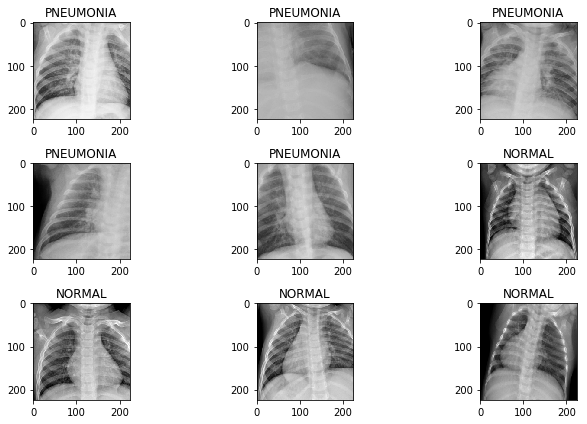

In [0]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [0]:
data

ImageDataBunch;

Train: LabelList (2657 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: dataset1;

Valid: LabelList (664 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,PNEUMONIA,NORMAL,PNEUMONIA,PNEUMONIA
Path: dataset1;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: dataset1

In [0]:

import torch 
import torchvision
resnet18PT = torchvision.models.resnet18(pretrained=True)

In [0]:
num_ftrs = resnet18PT.fc.in_features
resnet18PT.fc=nn.Sequential(
    
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 128),
    nn.Dropout(0.5),
    nn.Linear(128, 2),
)

In [0]:
resnet18PT=resnet18PT.cuda()

In [0]:


learn = Learner(data, resnet18PT, metrics=[error_rate, accuracy,])

In [0]:
learn.freeze()

In [20]:
learn.fit_one_cycle(7,0.0003)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.305242,0.134423,0.052711,0.947289,02:26
1,0.210250,0.270085,0.076807,0.923193,02:28
2,0.153884,0.178897,0.064759,0.935241,02:28
3,0.121282,0.107095,0.034639,0.965361,02:27
4,0.092513,0.117274,0.037651,0.962349,02:27
5,0.062765,0.129303,0.037651,0.962349,02:27
6,0.041316,0.102049,0.028614,0.971386,02:27


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

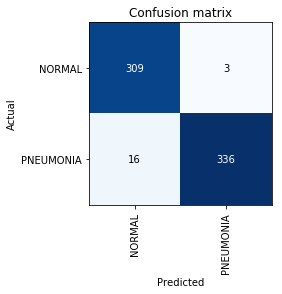

In [25]:
interp.plot_confusion_matrix()

In [0]:
learn.save('m1')

In [0]:
from fastai.callbacks import *
learn1 = Learner(data, resnet18PT, metrics=[accuracy, error_rate],
                callback_fns=[partial(CSVLogger, append=True)])

In [29]:
learn1.fit_one_cycle(15,0.0003,callbacks=[SaveModelCallback(learn, every='best', monitor='accuracy')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every best is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.056913,0.133711,0.965361,0.034639,02:27
1,0.064968,0.384506,0.905120,0.094880,02:26
2,0.074644,0.204012,0.932229,0.067771,02:26
3,0.081001,0.100231,0.972892,0.027108,02:26
4,0.103551,0.087652,0.965361,0.034639,02:27
5,0.094089,0.099331,0.966867,0.033133,02:26
6,0.072750,0.181027,0.948795,0.051205,02:25
7,0.072635,0.365131,0.926205,0.073795,02:27
8,0.060375,0.187698,0.945783,0.054217,02:27
9,0.051133,0.095532,0.975904,0.024096,02:26


In [0]:
interp = ClassificationInterpretation.from_learner(learn1)

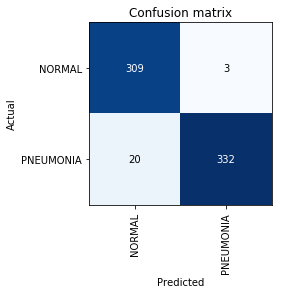

In [31]:
interp.plot_confusion_matrix()

In [0]:
learn1.save('Resnet18PTFT')

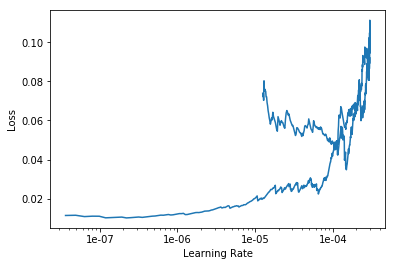

In [33]:
learn1.recorder.plot()

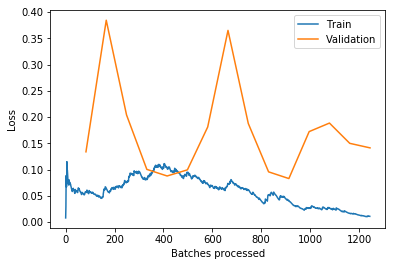

In [35]:
learn1.recorder.plot_losses()

In [0]:
preds = learn1.get_preds()

In [0]:
preds[1]